In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
list(getattr(tqdm, '_instances'))
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [7]:
stocks = [elem.split('.')[0] for elem in os.listdir('./data/preproc/1hour/')]
stocks

['AFLT',
 'IRAO',
 'MVID',
 'OGKB',
 'SPBE',
 'MTLRP',
 'SFIN',
 'KMAZ',
 'CBOM',
 'MSNG',
 'FEES',
 'LKOH',
 'FESH',
 'KROT',
 'LENT',
 'MDMG',
 'NKNCP',
 'VKCO',
 'UPRO',
 'MRKY',
 'SELG',
 'SGZH',
 'AKRN',
 'CHMK',
 'ENPG',
 'YAKG',
 'PMSBP',
 'RKKE',
 'GEMC',
 'LSRG',
 'MRKZ',
 'BANE',
 'CNTL',
 'PMSB',
 'KRKNP',
 'NMTP',
 'PLZL',
 'TATN',
 'AFKS',
 'UNKL',
 'APTK',
 'LNZL',
 'GMKN',
 'NSVZ',
 'LIFE',
 'RNFT',
 'VRSB',
 'YDEX',
 'UWGN',
 'TGKN',
 'ABRD',
 'HYDR',
 'ABIO',
 'WUSH',
 'RTKMP',
 'GTRK',
 'NLMK',
 'TATNP',
 'CNTLP',
 'BLNG',
 'ALRS',
 'GCHE',
 'VSMO',
 'LSNG',
 'TRNFP',
 'MGNT',
 'RENI',
 'NKHP',
 'TGKB',
 'ROLO',
 'IRKT',
 'MGTSP',
 'MTLR',
 'TGKA',
 'MSRS',
 'HEAD',
 'RUAL',
 'MRKV',
 'KLSB',
 'SIBN',
 'SNGS',
 'MSTT',
 'KAZTP',
 'DVEC',
 'NVTK',
 'RASP',
 'VTBR',
 'PHOR',
 'TTLK',
 'NKNC',
 'T',
 'KAZT',
 'AMEZ',
 'MRKU',
 'TRMK',
 'MOEX',
 'SBERP',
 'VEON-RX',
 'CHMF',
 'RTKM',
 'SMLT',
 'LNZLP',
 'MRKC',
 'MRKP',
 'UNAC',
 'KZOSP',
 'GAZP',
 'ROSN',
 'BELU',
 'ELFV

In [9]:
#1 day

dfs = []


for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
    dfs += [df.copy()]
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'


df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df.shape

100%|██████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 812.78it/s]


(972611, 8)

In [11]:
df.head()

,time,open,close,volume,low,high,ticker,tmos_close
0,2022-05-04 10:00:00,32.14,32.10,503380.0,31.46,32.68,AFLT,4.27
1,2022-05-04 11:00:00,32.10,31.38,191664.0,31.14,32.16,AFLT,4.20
2,2022-05-04 12:00:00,31.40,31.80,89256.0,31.38,31.92,AFLT,4.22
3,2022-05-04 13:00:00,31.80,31.36,87929.0,31.30,31.84,AFLT,4.21
4,2022-05-04 14:00:00,31.34,31.54,69671.0,31.14,31.58,AFLT,4.21


### Get Target

In [15]:
# Используем уже знакомую функцию :)

def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: 
        mask_val_first = np.array(df['close'] > val_first)      ### тут будущему мне поразбираться нужно будет
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        income_rate = res_price/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        income_rate = res_price/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        income_rate = res_price/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            income_rate = res_price/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            income_rate = res_price/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

### Итог: Рассмотрим детальнее percent_first=0.995, percent_second=1.005, hours_to_wait=1

In [19]:
indx = random.sample(range(df.shape[0]), 100_000)
#idx

In [96]:
df_result = get_df_target(df, indx, percent_first=0.98, percent_second=1.05, points_to_wait=14*5) #5 дней

100%|███████████████████████████████████████████████████████████████| 100000/100000 [00:23<00:00, 4314.62it/s]


In [23]:
df_result

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,188335,2024-03-22 10:00:00,8850.0000,DNF,CHMK,12 days 00:00:00,1.017514,9005.0000,188405
1,365447,2024-05-24 12:00:00,4239.5000,LOSE,YDEX,2 days 22:00:00,0.966505,4097.5000,365459
2,750528,2024-03-11 22:00:00,1718.8000,DNF,CHMF,7 days 00:00:00,1.008145,1732.8000,750598
3,655718,2023-08-03 15:00:00,134.7300,LOSE,VTBR,4 days 03:00:00,0.965115,130.0300,655749
4,705594,2022-05-26 16:00:00,0.1830,DNF,MRKU,11 days 22:00:00,1.049180,0.1920,705664
...,...,...,...,...,...,...,...,...,...
99995,103717,2023-01-18 13:00:00,35.0600,LOSE,FESH,1 days 23:00:00,0.966058,33.8700,103734
99996,829178,2024-01-24 12:00:00,714.1250,DNF,BELU,7 days 00:00:00,1.003676,716.7500,829248
99997,81466,2024-04-22 21:00:00,3.4765,LOSE,MSNG,6 days 14:00:00,0.966921,3.3615,81526
99998,865488,2022-11-30 15:00:00,226.0000,LOSE,SVAV,1 days 20:00:00,0.969027,219.0000,865502


In [86]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.689433
0.01    0.932563
0.10    0.961203
0.20    0.966005
0.30    0.968421
0.40    0.969980
0.50    0.995285
0.60    1.009545
0.70    1.028847
0.80    1.052142
0.90    1.059694
0.99    1.125392
1.00    1.772364
Name: income_rate, dtype: float64

In [89]:
df_result['result'].value_counts(normalize=True)

result
LOSE    0.40109
DNF     0.34046
WIN     0.25845
Name: proportion, dtype: float64

In [49]:
df_result['delta_time_bin'] = np.ceil(df_result['delta_time'] / pd.Timedelta(hours=24))

<Axes: xlabel='delta_time_bin'>

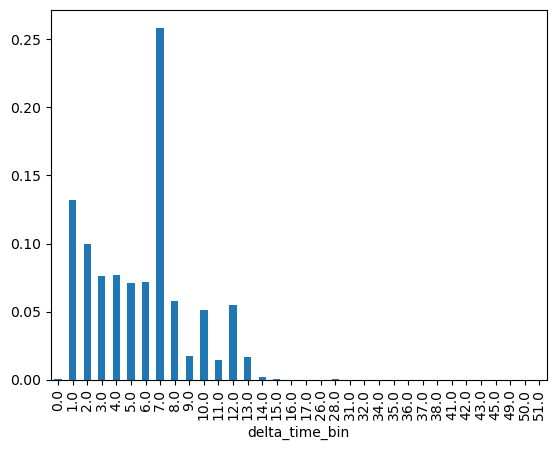

In [51]:
#распределение по длительности
df_result['delta_time_bin'].value_counts(normalize=True).sort_index().plot.bar()

In [129]:
#TR по времени ожидания

In [53]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_bin'>

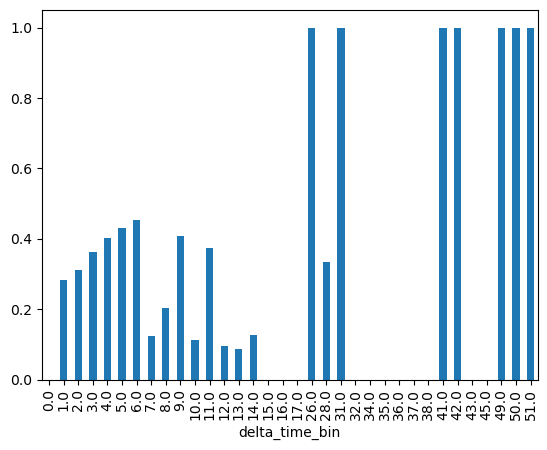

In [55]:
df_result.groupby('delta_time_bin').target.mean().sort_index().plot.bar()

In [59]:
#TR во времени

<Axes: xlabel='time'>

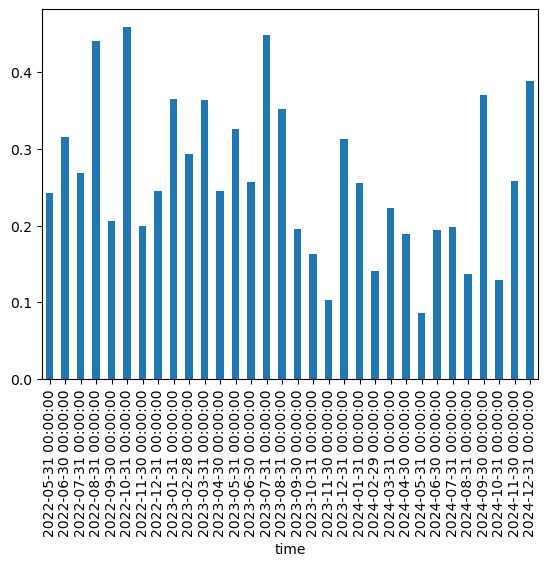

In [65]:
df_result.groupby(pd.Grouper(key='time', freq='ME')).target.mean().sort_index().plot.bar()

<Axes: xlabel='time'>

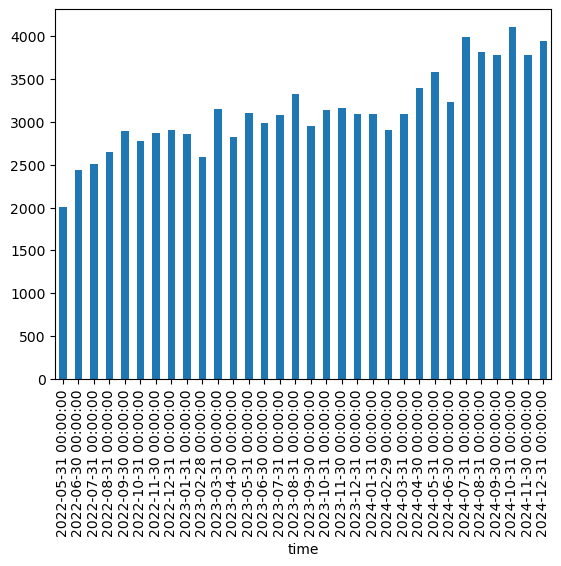

In [67]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='ME')).target.count().sort_index().plot.bar()

<Axes: xlabel='ticker'>

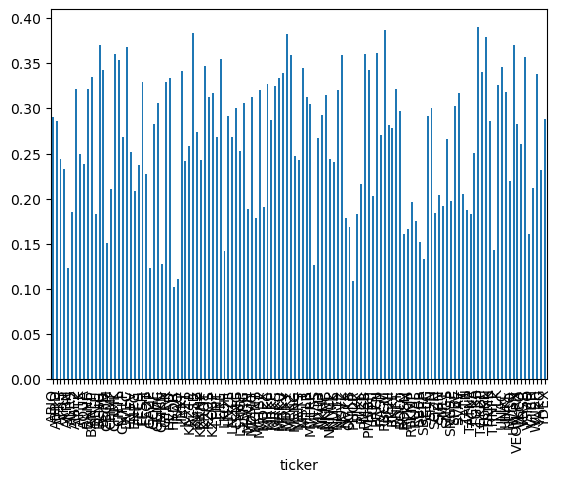

In [70]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()